# Identificação da raça do cachorro

## Autor

Lucas Gabriel Bezerra - 180125770

GitHub: [lucasgbezerra](https://github.com/lucasgbezerra/)

## Objetivo

O objetivo deste artigo é criar e treinar um modelo capaz de reconhecer cachorros das [10 raças mais populares do mundo em 2021](https://www.akc.org/expert-advice/dog-breeds/most-popular-dog-breeds-of-2021/).

## Motivação

O cachorro é popularmente conhecido como o melhor amigo do homem, e como um bom amigo o "homem" deve conhecer e cuidar do seu amigo.

Segundo o [FCI](https://www.fci.be/en/) (Federação Cinológica Internacional) [até 2018 eram reconhecidades 344 raças de cães](https://breedingbusiness.com/how-many-dog-breeds-are-there/), um número considerável e que torna difícil de identificar a raça de alguns cães.

Conhecer a raça do cachorro pode ser útil, tanto para os médicos veterinários que cuidam dos cães, quanto para seus "amigos humanos" que gostariam de conhecer melhor seus cães.

A partir dessa dificuldade de se conhecer tantas raças o uso de Machine Learning para o reconhecimento das diferentes raças pode ser uma boa maneira de facilitar o trabalho dos médicos veterinários e os apaixonados por cachorros.

## Modelagem

## Passo 1 - Instalando depêndencias

Instalação da biblioteca DuckDuckGo, com o gerenciador de pacotes pip, para realizar a busca pelas imagens utilizadas para o treinamento do modelo e realização de testes.

In [1]:
!pip install -Uqq duckduckgo_search

Instalação da biblioteca de deep learning fastai.

In [4]:
!pip install -Uqq fastai

Instalação da biblioteca lxml para buscar tabela de uma página web.

**Obs: Pode ser necessário restartar o kernel**

In [5]:
!pip install -Uqq lxml

## Passo 2 - Obtendo Lista das raças mais populares de 2021

Tratamento dos dados extraidos da da American Kennel Club para obter as raças de cachorros mais populares de 2021. 

Esses dados serão utilizados para realizar a pesquisa das imagens de maneira mais simples.

In [1]:
import pandas as pd
tables = pd.read_html('https://www.akc.org/expert-advice/dog-breeds/most-popular-dog-breeds-of-2021/')
df = tables[0]

In [3]:
df.columns = df.iloc[1]
df.drop([0, 1], inplace=True)
df.columns
df.drop(columns=[2021.0],axis=1,inplace=True)
df['BREED'] = df['BREED'].astype(str)
top10_breds = [x.replace('\xa0', ' ') for x in df['BREED'].tolist()]
top10_breds[:10]

## Passo 2 - Baixando imagens

Criação de uma função para buscar imagens(limitado a 40) a partir do termo passado como paramêtro utilizando a biblioteca do motor de pesquisa DuckDuckGo.

In [10]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=40):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Realizando teste de download com o cachorro de marley e eu

In [24]:
urls = search_images('dog marley and me', max_images=1)
urls[0]

'https://www.slashfilm.com/wp/wp-content/images/Marley-and-Me.jpg'

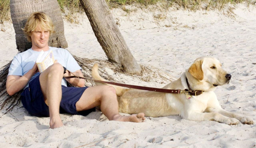

In [23]:
dest = 'marley.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Utilizando a função criada para buscar imagens, vamos buscar um conjunto de imagens de cachorros de diferentes raças. 

As imagens serão reduzidas e salvas em diretórios, onde cada pasta contem imagens de uma raça, para uso posterior.

In [6]:
searches = top10_breds[:10]
path = Path('dogs')

from fastdownload import download_url
from time import sleep

for breed in searches:
    dest = (path/breed)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{breed} photo'))
    sleep(5)
    resize_images(path/breed, max_size=400, dest=path/breed)


/home/lucas/Documents/am/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lucas/Documents/am/venv/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/lucas/Documents/am/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/lucas/Documents/am/venv/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Passo 2 - Treinando o Modelo

Antes de realizar o treinamento do modelo é indicado realizar uma verificação das imagens baixadas, a fim de buscar imagens que possam ter sido baixadas incorretamente e dessa forma possam causar falha no modelo treinado. As imagens baixadas incorretamente serão excluidas.

In [7]:
failed_imgs = verify_images(get_image_files(path))
failed_imgs.map(Path.unlink)
print(f"Número de imagens incorretas: {len(failed_imgs)}")

Número de imagens incorretas: 8


Para treinar o modelo é necessário utilizar *DataLoaders* que é um objeto composto por 2 conjuntos:
 1) **Conjunto de treinamento**: imagens utilizadas para a criação do modelo
 2) **Conjunto de validação**: imagens utilizadas para garantir a eficiência do modelo

*Obs: O conjunto de validação não é utilizado no treinamento.

O fastai utiliza o DataBloc para criar os DataLoaders

/home/lucas/Documents/am/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


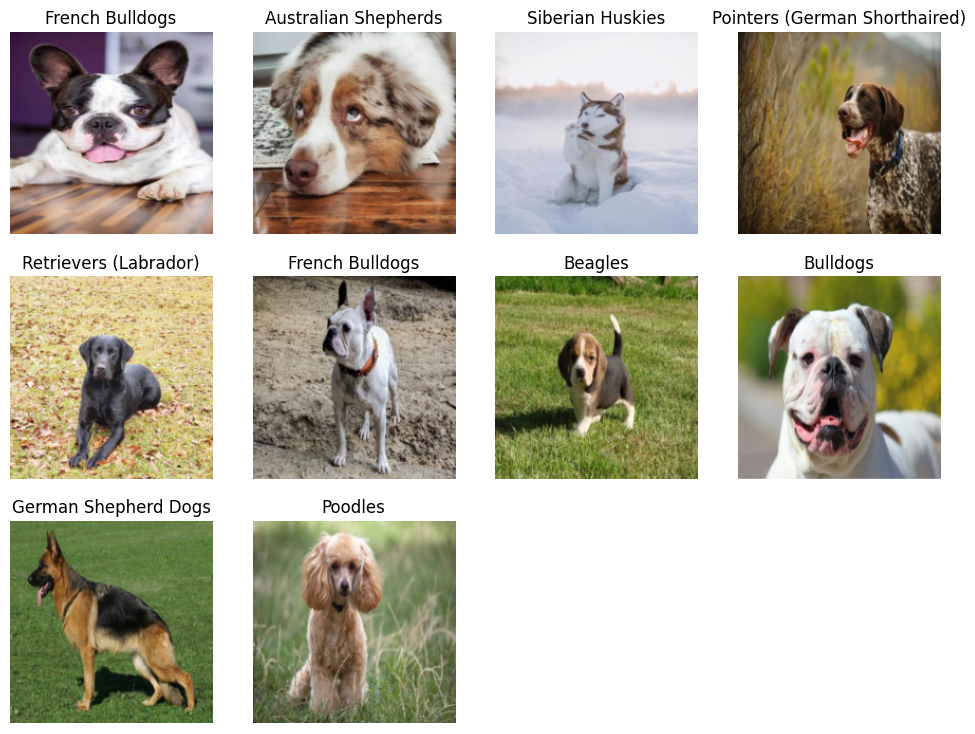

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

O Datablock é composto por diversos parâmetros, os parâmetros utilizados nessa modelagem foram:
- *blocks=(ImageBlock, CategoryBlock)*: o tipo de entrada(imagens de cachorro) e saídas (categorias ou raças de cachorros)
- *get_items=get_image_files*: retorna as lista de imagens armazenadas no path
- *splitter=RandomSplitter(valid_pct=0.2, seed=42)*: Divisão do dado entre conjunto de validação e de treinamento, sendo 20% dos dados para validação
- *get_y=parent_label*: o valor y é o nome do 'pai' de cada arquivo, que no caso em questão é a pasta com o a raça dele.
- *item_tfms=[Resize(192, method='squish')]*: reduz o tamanho da imagem antes do treinamento para 192x192 pixels.

O *.dataloaders(path, bs=32)* utiliza o caminho para as imagens e define o número de amostras para cada lote(batch)

E o método *show_batch* define um número de amostras a ser mostrada como 10

```python
dls.show_batch(max_n=10)
```



**Agora é hora de treinar o modelo**

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/home/lucas/Documents/am/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lucas/Documents/am/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.972072,0.239284,0.088415,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.306918,0.149096,0.051829,01:11
1,0.195386,0.106076,0.051829,01:13
2,0.135424,0.124074,0.039634,01:11
3,0.096647,0.098708,0.036585,01:09
4,0.073440,0.078548,0.024390,01:10
5,0.051281,0.072305,0.024390,01:10
6,0.039163,0.065186,0.015244,01:10
7,0.028391,0.050949,0.024390,01:11
8,0.020972,0.068426,0.030488,01:13
9,0.016741,0.065563,0.027439,01:10


Para treinar o modelo foi utilizado o modelo de visão(*vision model*) **resnet18** que é muito veloz.

Além disso o fastai possui o **fine_tune()** que é um método para 'tunar' um modelo, onde ele parte de pesos de uma rede treinada para treinar o modelo desejado.

### Problema encontrado

Ao tentar executar **learn.fine_tune()** no dia 01/10/2021 o seguinte erro foi retornado:

- *'Exception occured in ProgressCallback when calling event after_batch - preventing from running even the basic fastai tutorials'*
    
O erro se refere ao **Callback** (lidar com a exibição de barras de progresso), retornada ao executar o método para utilizar uma rede neural pré-treinada para reconhecer os grupos. Esse problema de formatação esta relacionado a uma incompatibilidade da versão 2.7.8 do fastai com o pytorch 1.13 (últimas versões LTS de ambos).

Para **corrigir o erro** foi utilizado a remoção do callback com a seguinte linha de código(learn.remove_cb(ProgressCallback):

```python
learn.remove_cb(ProgressCallback)
```
Implica a remoção da barra de progresso, e perde a formatação de tabela mostrada, ainda assim é possível visualizar os dados em formato de lista ou utilizando o atributo *cbs=CSVLogger()* Gerar um documento csv para visualização do histórico de treinamento.

**No dia 02/10, a [release 2.7.10 do fastai](https://github.com/fastai/fastai/releases/tag/2.7.10) foi lançada e corrigiu esse erro** que pode ser melhor que estava especificado nas issues: [#3809](https://github.com/fastai/fastai/issues/3809) e [#3828](https://github.com/fastai/fastai/pull/3828). Dessa forma o código foi alterado removendo a solução explicada a cima e apenas atualizando a versão do fastai.

## Passo 3 - Testando o modelo

Para utilizar o modelo basta usar a linha de código a seguir com uma imagem do cachorro. Será retornada a raça do cachorro e a probabilidade de correspondência obtida.

```python

dog_breed,_, probs = learn.predict(PILImage.create('imagem.jpg'))
```

In [15]:
dog_breed,_, probs = learn.predict(PILImage.create('marley.jpg'))

high_prob= probs.sort()[0][-1]*100
print(f'Probabilidade de ser um {dog_breed} é de {probs.sort()[0][-1]*100:.2f}%')
    

Probabilidade de ser um Retrievers (Labrador) é de 59.72%


## Conclusão

Como existem centenas de raças para facilitar a execução o número de raças utilizados foi de 10, o que diminui o tempo e a quantidade de dados necessários para realizar a modelagem.

A identificação das raças não é simples, visto a semelhança entre algumas raças, e requer uma consideravel quantidade de amostras e epocas de treinamento para aumentar consideravelmente a acertividade.

Identificar a raça de um cachorro é algo complexo pra humanos, inclusive para aqueles que possuem conhecimento sobre o mundo canino. 

O uso de Machine Learning e o modelo criado com uma acúracia alta como a exemplifica torna-o apto para ser utilizado para fins de conhecimento, em caso de uso médico a taxa de erro deve estar mais próxima de zero e provavelmente seria útil utilizar outras formas de identificar uma raça além de imagens. Ainda assim o modelo pode gerar uma primeira análise sobre a raça de um cachorro.